# Exercises

In [104]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import poisson
%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets
import seaborn as sns


track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

In [2]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

In [3]:
# GENERATE TRAJECTORY

n_runs = 10
use_stops = False
av_running_speed = 10 # the average running speed (in cm/s)
fps = 10 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])


for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))
t = np.arange(len(x))/fps

In [4]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

In [5]:
import pickle

file_name = 'linear_track_data.pickle' # change this name when you save new data

out_data = {}
out_data['x'] = x
out_data['t'] = t
out_data['spikes'] = spikes
out_data['track_length'] = track_length
out_data['fps'] = fps

with open('data/'+file_name,'wb') as f:
    pickle.dump(out_data,f)

## Exercise 1
---

You can find below the code that was used to generate the activity of place cells on a linear track.
Use the code and the decoding procedure you lerned about in the lesson to explore how different features of the data impact our ability to decode position.
In particular:

A - Try to use different fractions of our data samples. How does the median error change when the the number of available sample gets larger? You do not need to re-generate any data, just randomly sub-sample the data to different fractions.

B - How many place cells do we need to reliably decode position? Try to re-do the decoding using only 10 cell, then 20, and so on. How does the median error change? Does it reach an asymptote? (Also in this case, you do not need to re-generate the data, you can just select a random subset of cells each time)

C - Generate new data using the code below, changing the firing rate noise (changing the value of the variable `noise firing_rate`). How does this noise impact the decoding? 

exercise 1-A

100%|██████████| 436/436 [00:00<00:00, 8709.87it/s]


Fraction: 0.1, Median Error: 8.413662239089177


100%|██████████| 874/874 [00:00<00:00, 9305.67it/s]


Fraction: 0.2, Median Error: 4.95640495867768


100%|██████████| 1311/1311 [00:00<00:00, 9488.95it/s]


Fraction: 0.3, Median Error: 3.983098591549293


100%|██████████| 1749/1749 [00:00<00:00, 9865.80it/s]


Fraction: 0.4, Median Error: 3.7450199203187253


100%|██████████| 2187/2187 [00:00<00:00, 9962.60it/s] 


Fraction: 0.5, Median Error: 3.3452400082642697


100%|██████████| 3499/3499 [00:00<00:00, 9995.83it/s] 


Fraction: 0.8, Median Error: 3.3954372623574045


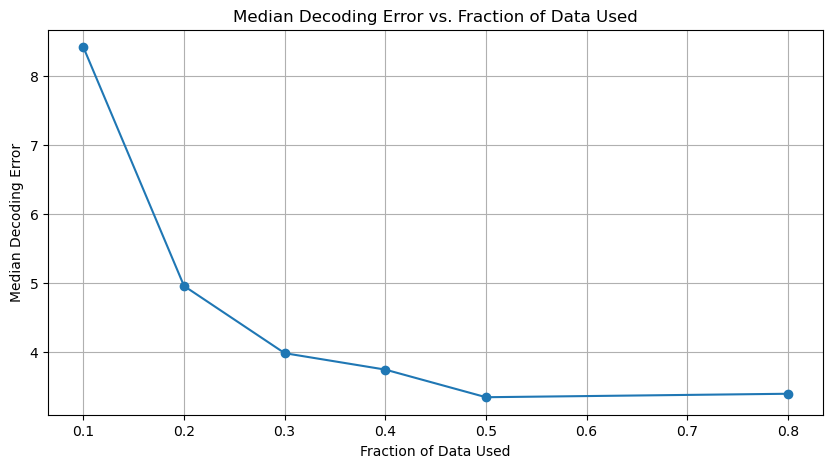

In [60]:
fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]

# Perform decoding for each fraction
median_errors = np.zeros(len(fractions))

for i, fraction in enumerate(fractions):
    num_samples = int(len(x) * fraction)
    random_indices = np.sort(np.random.choice(len(x), size=num_samples, replace=False))
    sub_x = x[random_indices]
    sub_t = t[random_indices]
    spike_positions = [np.interp(s, sub_t, sub_x) for s in spikes]
    space_bins = np.arange(0., track_length, 5.)  # binning in bins of 5 cms

    # Compute histograms for each cell
    spikes_hist = np.array([np.histogram(s, space_bins)[0] for s in spike_positions])

    # Compute occupancy histogram to normalize the firing rates maps
    occupancy = np.histogram(sub_x, space_bins)[0] / fps
    occupancy[occupancy == 0] = np.nan
    firing_rate_maps = spikes_hist / occupancy

    # Compute spike counts
    spikes_count = np.array([np.histogram(s, sub_t)[0] for s in spikes]).T  # Transpose to have samples x features shape

    true_x = sub_x[:-1]
    decoding_times = sub_t[:-1]
    x_decoded = np.full_like(true_x, np.nan)  # Initialize with NaNs

    # Calculate posterior and decode
    for t_bin in tqdm(range(len(decoding_times))):
        if np.sum(spikes_count[t_bin, :]) > 0:  # Check if the time window contains spikes
            posterior = np.nansum(poisson.logpmf(spikes_count[t_bin, :, None], firing_rate_maps / fps), axis=0)
            x_decoded[t_bin] = space_bins[np.nanargmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan   

    # Compute error
    valid_indices = ~np.isnan(x_decoded)
    mse = np.sqrt((true_x[valid_indices] - x_decoded[valid_indices])**2)
    median_error = np.nanmedian(mse)
    median_errors[i] = median_error
    print(f"Fraction: {fraction:.1f}, Median Error: {median_error}")

# Plotting the results
plt.plot(fractions, median_errors, marker='o')
plt.xlabel('Fraction of Data Used')
plt.ylabel('Median Decoding Error')
plt.title('Median Decoding Error vs. Fraction of Data Used')
plt.grid(True)
plt.show()

the median error decrease, at 0.5 the optimum seems to be reached

excercise 1-B

100%|██████████| 4375/4375 [00:00<00:00, 49482.47it/s]


Number of Cells: 10, Median Error: 8.087323943661971


100%|██████████| 4375/4375 [00:00<00:00, 28033.36it/s]


Number of Cells: 20, Median Error: 7.327008783495195


100%|██████████| 4375/4375 [00:00<00:00, 22937.86it/s]


Number of Cells: 30, Median Error: 6.596958174904955


100%|██████████| 4375/4375 [00:00<00:00, 18492.14it/s]


Number of Cells: 40, Median Error: 5.03206997084547


100%|██████████| 4375/4375 [00:00<00:00, 15785.50it/s]


Number of Cells: 50, Median Error: 4.793388429752071


100%|██████████| 4375/4375 [00:00<00:00, 11730.01it/s]


Number of Cells: 80, Median Error: 3.7963655581754665


100%|██████████| 4375/4375 [00:00<00:00, 10089.10it/s]

Number of Cells: 100, Median Error: 3.4127134724857626


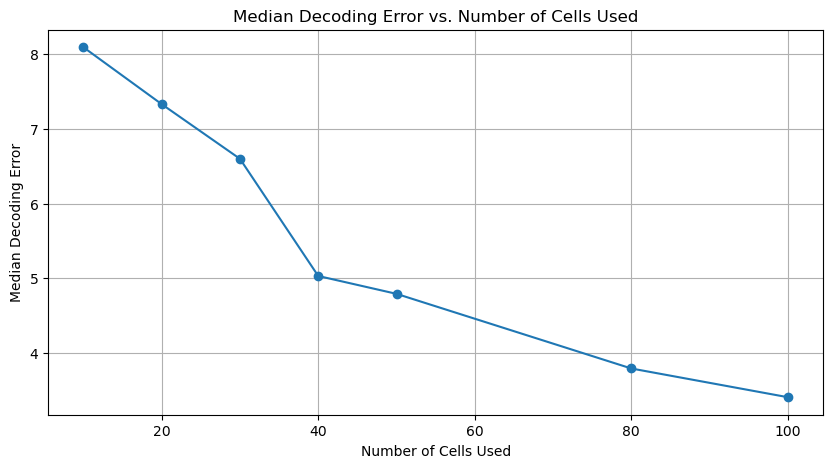

In [70]:
n_cells_list = [10, 20, 30, 40, 50, 80, 100]

# Perform decoding for each fraction
median_errors = np.zeros(len(n_cells_list))

for i, num_cells in enumerate(n_cells_list):
    # Randomly select num_cells from spikes
    selected_indices = np.sort(np.random.choice(len(spikes), size=num_cells, replace=False))
    selected_spikes = [spikes[idx] for idx in selected_indices]
    
    spike_positions = [np.interp(s, t, x) for s in selected_spikes]
    space_bins = np.arange(0., track_length, 5.)  # binning in bins of 5 cms

    # Compute histograms for each cell
    spikes_hist = np.array([np.histogram(s, space_bins)[0] for s in spike_positions])

    # Compute occupancy histogram to normalize the firing rates maps
    occupancy = np.histogram(x, space_bins)[0] / fps
    occupancy[occupancy == 0] = np.nan
    firing_rate_maps = spikes_hist / occupancy

    # Compute spike counts
    spikes_count = np.array([np.histogram(s, t)[0] for s in selected_spikes]).T  # Transpose to have samples x features shape

    true_x = x[:-1]
    decoding_times = t[:-1]
    x_decoded = np.full_like(true_x, np.nan)  # Initialize with NaNs

    # Calculate posterior and decode
    for t_bin in tqdm(range(len(decoding_times))):
        if np.sum(spikes_count[t_bin, :]) > 0:  # Check if the time window contains spikes
            posterior = np.nansum(poisson.logpmf(spikes_count[t_bin, :, None], firing_rate_maps / fps), axis=0)
            x_decoded[t_bin] = space_bins[np.nanargmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan   

    # Compute error
    valid_indices = ~np.isnan(x_decoded)
    mse = np.sqrt((true_x[valid_indices] - x_decoded[valid_indices])**2)
    median_error = np.nanmedian(mse)
    median_errors[i] = median_error
    print(f"Number of Cells: {num_cells}, Median Error: {median_error}")

# Plotting the results
plt.plot(n_cells_list, median_errors, marker='o')
plt.xlabel('Number of Cells Used')
plt.ylabel('Median Decoding Error')
plt.title('Median Decoding Error vs. Number of Cells Used')
plt.grid(True)
plt.show()

Also here you can see a decrease in the median error, as the number of cells increase.

exercise 1-C

100%|██████████| 4375/4375 [00:00<00:00, 9806.54it/s]


Noise Level: 0.0, Median Error: 3.4127134724857626


100%|██████████| 4375/4375 [00:00<00:00, 8367.79it/s]


Noise Level: 0.1, Median Error: 11.454971233468939


100%|██████████| 4375/4375 [00:00<00:00, 8270.40it/s]


Noise Level: 0.2, Median Error: 47.64093712602412


100%|██████████| 4375/4375 [00:00<00:00, 8309.58it/s]


Noise Level: 0.3, Median Error: 54.71405460958712


100%|██████████| 4375/4375 [00:00<00:00, 8294.04it/s]


Noise Level: 0.4, Median Error: 64.95040981448656


100%|██████████| 4375/4375 [00:00<00:00, 8478.69it/s]


Noise Level: 0.5, Median Error: 67.06359915363004


100%|██████████| 4375/4375 [00:00<00:00, 8509.57it/s]


Noise Level: 0.8, Median Error: 70.32831384981178


100%|██████████| 4375/4375 [00:00<00:00, 8500.70it/s]

Noise Level: 1.0, Median Error: 66.96487628613424


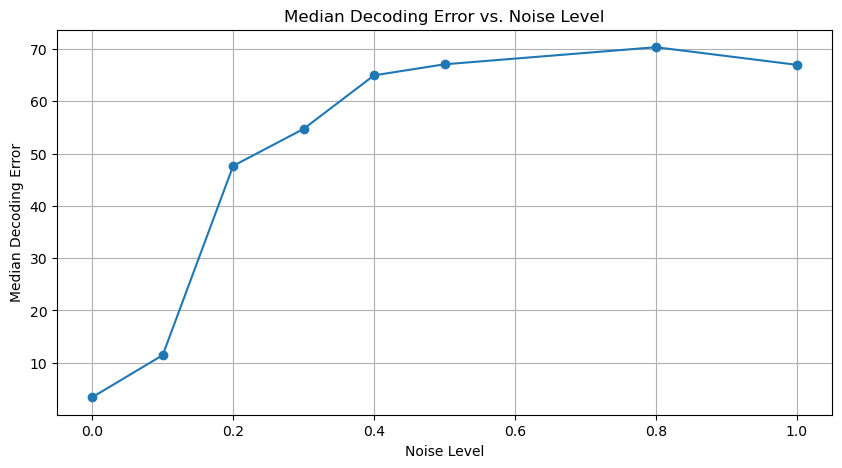

In [73]:
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1]

# Perform decoding for each noise level
median_errors = np.zeros(len(noise_levels))

for i, noise_level in enumerate(noise_levels):
    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., track_length, 5.)  # binning in bins of 5 cms

    # Compute histograms for each cell
    spikes_hist = np.array([np.histogram(s, space_bins)[0] for s in spike_positions])

    # Compute occupancy histogram to normalize the firing rates maps
    occupancy = np.histogram(x, space_bins)[0] / fps
    occupancy[occupancy == 0] = np.nan
    firing_rate_maps = spikes_hist / occupancy

    # Add noise to the firing rate maps
    noise = np.random.normal(0, noise_level, firing_rate_maps.shape)
    noisy_firing_rate_maps = firing_rate_maps + noise

    # Compute spike counts
    spikes_count = np.array([np.histogram(s, t)[0] for s in spikes]).T  # Transpose to have samples x features shape

    true_x = x[:-1]
    decoding_times = t[:-1]
    x_decoded = np.full_like(true_x, np.nan)  # Initialize with NaNs

    # Calculate posterior and decode
    for t_bin in tqdm(range(len(decoding_times))):
        if np.sum(spikes_count[t_bin, :]) > 0:  # Check if the time window contains spikes
            posterior = np.nansum(poisson.logpmf(spikes_count[t_bin, :, None], noisy_firing_rate_maps / fps), axis=0)
            x_decoded[t_bin] = space_bins[np.nanargmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan   

    # Compute error
    valid_indices = ~np.isnan(x_decoded)
    mse = np.sqrt((true_x[valid_indices] - x_decoded[valid_indices])**2)
    median_error = np.nanmedian(mse)
    median_errors[i] = median_error
    print(f"Noise Level: {noise_level:.1f}, Median Error: {median_error}")

# Plotting the results
plt.plot(noise_levels, median_errors, marker='o')
plt.xlabel('Noise Level')
plt.ylabel('Median Decoding Error')
plt.title('Median Decoding Error vs. Noise Level')
plt.grid(True)
plt.show()


here you can see an increase in the median error, thus the noise levels negatively impact the decoding

## Exercise 2
---
In the loop implementation of the decoder, we used `poisson.logpmf(k,mu)` to calculate the log probability of observing $k$ spikes given an average firing rate of $\mu$. 
This is mathematically equivalent to `np.log(poisson.pmf(k,mu))`, in which we calculate the probability, and then take the log.


Re-run the decoding substituting this expression:

```
posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
```

To the line we are using to calculate the posterior.
Do you see any difference in the results? What do you think this is due to?




100%|██████████| 4375/4375 [00:03<00:00, 1116.60it/s]


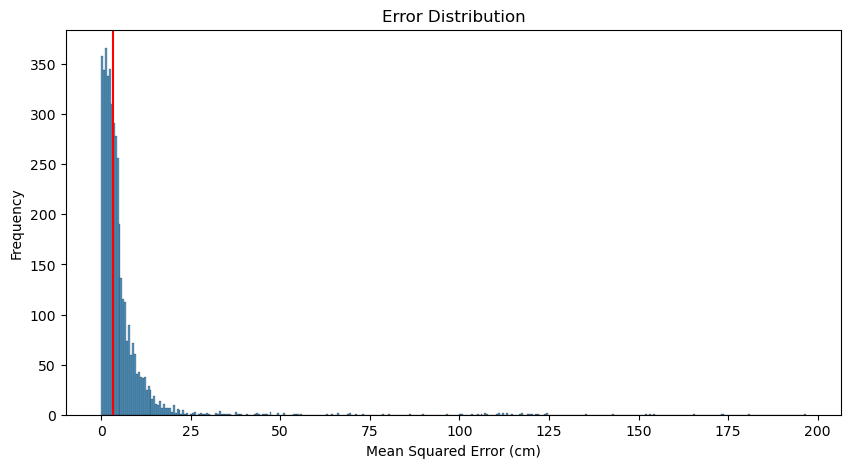

Median error: 3.4382885913650796 cm


In [103]:
noise_firing_rate = 0.1  # the baseline noise firing rate

# Vectorized spikes generation
spikes = []
for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., track_length, 5.)  # binning in bins of 5 cms
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
spikes_hist = np.asarray(spikes_hist)

# Compute occupancy histogram to normalize the firing rates maps
occupancy= np.histogram(x, space_bins)[0] / fps

# Compute firing rate maps
firing_rate_maps = spikes_hist / occupancy # Ensure occupancy has proper shape

# Transpose spikes count matrix
spikes_count = np.array([np.histogram(s, t)[0] for s in spikes]).T  # Transpose to get samples x features shape

# Decode positions
true_x = x[:-1]
decoding_times = t[:-1]
x_decoded = np.full_like(true_x, np.nan)

# Calculate posterior and decode
for t_bin in tqdm(range(len(decoding_times))):
    if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
        posterior = np.empty(firing_rate_maps.shape[-1])

        for j in range(len(posterior)):
            # Note that we work with log so that we can sum probabilities
            # instead of multiplying them 
            #posterior[j] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,j]/fps)+pow(1,-15)))
            posterior[j] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,j]/fps)+pow(1,-15))
        x_decoded[t_bin] = space_bins[np.argmax(posterior)]
    else:
        x_decoded[t_bin] = np.nan

# Compute error distribution
mse = np.sqrt((true_x - x_decoded) ** 2)
sns.histplot(mse, kde=False)
plt.axvline(x=np.nanmedian(mse), color='r')
plt.xlabel('Mean Squared Error (cm)')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.show()
print(f'Median error: {np.nanmedian(mse)} cm')

with the np.log(poisson.pmf), i get a median error of 34.82 cm.
With the sum(poisson.logpmf) i get a median error of 3.44 cm.

## Exercise 3
---
A - Estimate the quality of the sequence detection methods we saw in the lesson. How many false poistive does it find? How many false negatives?

B - Investigate the effect of `noise_x_react` and `noise_t_react` on the false positive rate and the false negative rate of our detection procedure.

C - What kind of sequence can our methods detect? What kind of activity, despide being sequential, could escape our detection method? Would you have an idea for a different method for sequence detection?


### Code for data generation

In [105]:
# generate data 

n_events = 200 # number of reactivation events
event_duration = 100 # in bins
sampling_rate = 100 # sampling rate 
t_react = np.arange(0,100)
noise_x_react=5; # Noise in the reactivation of the sequence
noise_t_react=5; # Noise in the timing of the spikes 
noise_firing_rate = 0.1 # the baseline noise firing rate


reactivation_events = np.zeros((n_events,event_duration))
spikes_react = np.zeros((n_events,n_cells,event_duration))

for event in range(n_events):
    if(event<=n_events//2):
    #Generate "real" sequences for the first half of events
        x_start = np.random.uniform(0,track_length) # Starting point
        x_end = np.random.uniform(0,track_length) # Ending point
        x_react = np.linspace(x_start,x_end,event_duration) \
            +np.random.normal(0,noise_x_react,size=event_duration)

    else:
        #Pick locations randomly for the second half 
        x_react = np.random.uniform(0,track_length,size=event_duration);

    x_react[x_react<0]=0;
    x_react[x_react>track_length]=track_length
    
    #store reactivation sequence
    reactivation_events[event,:] = x_react

    
    # Generate spikes according to the location being reactivated in this event
    
    for i in range(n_cells):
        binned_x = np.digitize(x_react,bins=np.linspace(0,track_length,firing_rate_maps.shape[-1]))-1
        inst_rate = firing_rate_maps[i,binned_x] + np.random.normal(0,noise_firing_rate,size=len(binned_x))
        inst_rate[inst_rate<0] = 0
        spikes_loc = np.where(np.random.poisson(inst_rate/sampling_rate)>0)
        spikes_loc = spikes_loc + np.round(np.random.normal(0,noise_t_react,size=len(spikes_loc)))
        spikes_loc = spikes_loc[np.logical_and(spikes_loc>0,spikes_loc<event_duration)]
        spikes_react[event,i,spikes_loc.astype(int)] = 1

In [106]:
pfc_idxs = [np.argmax(rate_map) for rate_map in firing_rate_maps] 
sorted_idxs = np.argsort(pfc_idxs)

In [107]:
time_window = 10 # number of bins to aggregate during decoding

reactivation_slope = np.zeros(n_events)

for event in range(n_events):

    event_spikes = spikes_react[event]
    # First we bin the events in windows of 10 bins
    spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//time_window))
    # We generate a new spike matrix with the re-sized window
    for t_r in range(1,event_spikes.shape[1]//time_window):
        spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*time_window :(t_r)*time_window],axis=1)

exercise 3-A

In [123]:
n_events = 200  # number of reactivation events
event_duration = 100  
sampling_rate = 100  
t_react = np.arange(0, 100)
noise_x_react = 5  
noise_t_react = 5  
noise_firing_rate = 0.1  
track_length = 100  
n_cells = 50  
firing_rate_maps = np.random.rand(n_cells, 20) 
fps = 30  
space_bins = np.linspace(0, track_length, 20)  

reactivation_events = np.zeros((n_events, event_duration))
spikes_react = np.zeros((n_events, n_cells, event_duration))

for event in range(n_events):
    if event <= n_events // 2:
        x_start = np.random.uniform(0, track_length)  
        x_end = np.random.uniform(0, track_length)  
        x_react = np.linspace(x_start, x_end, event_duration) + np.random.normal(0, noise_x_react, size=event_duration)
    else:
        x_react = np.random.uniform(0, track_length, size=event_duration)

    x_react[x_react < 0] = 0
    x_react[x_react > track_length] = track_length
    
    reactivation_events[event, :] = x_react

    for i in range(n_cells):
        binned_x = np.digitize(x_react, bins=np.linspace(0, track_length, firing_rate_maps.shape[-1])) - 1
        inst_rate = firing_rate_maps[i, binned_x] + np.random.normal(0, noise_firing_rate, size=len(binned_x))
        inst_rate[inst_rate < 0] = 0
        spikes_loc = np.where(np.random.poisson(inst_rate / sampling_rate) > 0)[0]
        spikes_loc = spikes_loc + np.round(np.random.normal(0, noise_t_react, size=len(spikes_loc)))
        spikes_loc = spikes_loc[np.logical_and(spikes_loc > 0, spikes_loc < event_duration)]
        spikes_react[event, i, spikes_loc.astype(int)] = 1

# to do: bayesian decoding
t_resize = 10  # We use spikes from multiple time windows for the decoding

reactivation_slopes = np.zeros(n_events)
reactivation_pvalues = np.zeros(n_events)

for event in range(n_events):
    event_spikes = spikes_react[event]
    spikes_sampled = np.zeros((n_cells, event_spikes.shape[1] // t_resize))

    # We generate a new spike matrix with the re-sized window
    for t_r in range(1, event_spikes.shape[1] // t_resize):
        spikes_sampled[:, t_r] = np.sum(event_spikes[:, (t_r - 1) * t_resize: t_r * t_resize], axis=1)
    
    # We then perform decoding on the aggregated spikes
    x_decoded = np.zeros(spikes_sampled.shape[1])

    for t_bin in range(spikes_sampled.shape[1]):
        if sum(spikes_sampled[:, t_bin]) > 0: # Check if the time window contains spikes
            posterior = np.empty(firing_rate_maps.shape[-1])
            for i in range(len(posterior)):
                posterior[i] = sum(poisson.logpmf(spikes_sampled[:, t_bin], firing_rate_maps[:, i] * t_resize / fps) + pow(1, -15))
            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan
            
    # We fit a line to the decoded positions, and save the slope
        idx = np.isfinite(x_decoded)
        slope, _ = np.polyfit(np.arange(len(x_decoded))[idx], x_decoded[idx], deg=1)
        reactivation_slopes[event] = slope
        # And calculate the pvalue of the pearson correlation
        corr = pearsonr(np.arange(len(x_decoded))[idx], x_decoded[idx])
        reactivation_pvalues[event] = corr[1]

p_value_threshold = 0.05
event_detections = []

for event in range (n_events):
    if reactivation_pvalues[event] < p_value_threshold:
        event_detections.append(event)
event_detections = np.array(event_detections)

ground_truth = np.arange(100)
false_positives = np.setdiff1d(event_detections, ground_truth)
false_negatives = np.setdiff1d(ground_truth, event_detections)
false_positives = sum((reactivation_pvalues[n_events//2:] < p_value_threshold))
false_negatives = sum((reactivation_pvalues[:n_events//2] >= p_value_threshold))



print(f"False Positives: {false_positives}")
print(f"False Negatives: {false_negatives}")



False Positives: 6
False Negatives: 93


exercise 3-B

In [161]:
# Define parameters
noise_values = np.array([0, 0.2, 0.4, 0.6, 0.8, 1, 2, 4, 8, 16, 32])
false_p_n = np.zeros([len(noise_values), 2])

n_events = 200  
event_duration = 100  
sampling_rate = 100  
time_window = 10 
t_resize = 10  
n_cells = 10 
track_length = 50  
fps = 10


firing_rate_maps = np.random.rand(n_cells, 20)

# Assuming reactivation_pvalues is defined somewhere in the script
reactivation_pvalues = np.random.rand(n_events)

for i in tqdm(range(len(noise_values))):
    noise_x_react = noise_values[i]  
    noise_t_react = noise_values[i]  
    noise_firing_rate = 0.1 

    reactivation_events = np.zeros((n_events, event_duration))
    spikes_react = np.zeros((n_events, n_cells, event_duration))

    for event in range(n_events):
        if event <= n_events // 2:
            # Generate "real" sequences for the first half of events
            x_start = np.random.uniform(0, track_length)  
            x_end = np.random.uniform(0, track_length)  
            x_react = np.linspace(x_start, x_end, event_duration) + np.random.normal(0, noise_x_react, size=event_duration)
        else:
            # Pick locations randomly for the second half
            x_react = np.random.uniform(0, track_length, size=event_duration)

        # Ensure x_react values are within the track length
        x_react[x_react < 0] = 0
        x_react[x_react > track_length] = track_length

        # Store reactivation sequence
        reactivation_events[event, :] = x_react

        # Generate spikes according to the location being reactivated in this event
        for cell in range(n_cells):
            binned_x = np.digitize(x_react, bins=np.linspace(0, track_length, firing_rate_maps.shape[1])) - 1
            # Ensure the indices are within the bounds
            binned_x[binned_x >= firing_rate_maps.shape[1]] = firing_rate_maps.shape[1] - 1
            binned_x[binned_x < 0] = 0
            
            inst_rate = firing_rate_maps[cell, binned_x] + np.random.normal(0, noise_firing_rate, size=len(binned_x))
            inst_rate[inst_rate < 0] = 0
            spikes_loc = np.where(np.random.poisson(inst_rate / sampling_rate) > 0)[0]
            spikes_loc = spikes_loc + np.round(np.random.normal(0, noise_t_react, size=len(spikes_loc))).astype(int)
            spikes_loc = spikes_loc[np.logical_and(spikes_loc > 0, spikes_loc < event_duration)]
            spikes_react[event, cell, spikes_loc] = 1

    reactivation_slopes = np.zeros(n_events)
    reactivation_pvalues = np.zeros(n_events)

    for event in range(n_events):
        event_spikes = spikes_react[event]
        spikes_sampled = np.zeros((n_cells, event_spikes.shape[1] // t_resize))

        # Generate a new spike matrix with the re-sized window
        for t_r in range(1, event_spikes.shape[1] // t_resize):
            spikes_sampled[:, t_r] = np.sum(event_spikes[:, (t_r - 1) * t_resize: t_r * t_resize], axis=1)

        # Perform decoding on the aggregated spikes
        x_decoded = np.zeros(spikes_sampled.shape[1])
        space_bins = np.linspace(0, track_length, firing_rate_maps.shape[1])

        for t_bin in range(spikes_sampled.shape[1]):
            if np.sum(spikes_sampled[:, t_bin]) > 0:  # Check if the time window contains spikes
                posterior = np.empty(firing_rate_maps.shape[-1])
                for j in range(len(posterior)):
                    posterior[j] = np.sum(poisson.logpmf(spikes_sampled[:, t_bin], firing_rate_maps[:, j] * t_resize / fps))
                x_decoded[t_bin] = space_bins[np.argmax(posterior)]
            else:
                x_decoded[t_bin] = np.nan

        # Fit a line to the decoded positions, and save the slope
        idx = np.isfinite(x_decoded)
        if np.sum(idx) > 1:  
            slope, _ = np.polyfit(np.arange(len(x_decoded[idx])), x_decoded[idx], deg=1)
            reactivation_slopes[event] = slope
            # Calculate the p-value of the Pearson correlation
            corr = pearsonr(np.arange(len(x_decoded[idx])), x_decoded[idx])
            reactivation_pvalues[event] = corr[1]


    p_value_threshold = 0.05
    event_detections = []

    for event in range(n_events):
        if reactivation_pvalues[event] < p_value_threshold:
            event_detections.append(event)
    event_detections = np.array(event_detections)

    
    ground_truth = np.arange(n_events // 2)  
    false_positives = np.setdiff1d(event_detections, ground_truth)
    false_negatives = np.setdiff1d(ground_truth, event_detections)

    num_false_positives = len(false_positives)
    num_false_negatives = len(false_negatives)
    false_p_n[i, 0] = num_false_positives
    false_p_n[i, 1] = num_false_negatives

print(false_p_n)


100%|██████████| 11/11 [00:04<00:00,  2.65it/s]

[[ 7. 95.]
 [ 4. 93.]
 [10. 97.]
 [12. 86.]
 [ 8. 93.]
 [10. 95.]
 [ 7. 93.]
 [ 5. 92.]
 [16. 91.]
 [15. 85.]
 [12. 84.]]


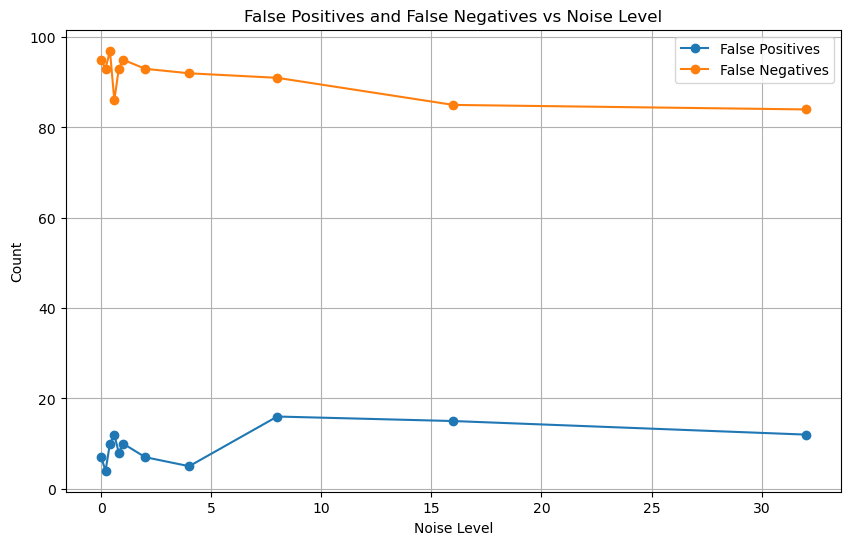

In [162]:
plt.figure(figsize=(10, 6))
plt.plot(noise_values, false_p_n[:, 0], label='False Positives', marker='o')
plt.plot(noise_values, false_p_n[:, 1], label='False Negatives', marker='o')
plt.xlabel('Noise Level')
plt.ylabel('Count')
plt.title('False Positives and False Negatives vs Noise Level')
plt.legend()
plt.grid(True)
plt.show()

It seems that the noise level has little effect on our false positives and negatives. There is a small increase in false positives with greater noise levels. However, this result is still pretty good.

Exercise 3-C


We find that, our strategy is effective for recording successive events. Nevertheless, there are circumstances in which our system could fail to recognize a sequence event. For instance, it can have trouble identifying sequential activity that happens very quickly. Rapidly occurring sequential events may not be adequately recorded if our sample rate is too low or our time frame is too wide.

Furthermore, our method assumes a linear route for consecutive activity patterns and fits straight lines to estimate slopes. Which might lead to not being able to adequately capture the underlying sequence in cases when sequential activity shows complicated dynamics or a non-linear trajectory.

